In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data = pd.read_csv("wly.csv")

In [3]:
data.shape

(4404, 7)

In [4]:
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-02-13 09:30:00+08:00,203.899994,206.259995,203.509995,205.940002,205.940002,978400
1,2023-02-13 09:32:00+08:00,205.809998,207.410004,205.160004,206.720001,206.720001,677560
2,2023-02-13 09:34:00+08:00,206.720001,208.589996,206.720001,208.479996,208.479996,703468
3,2023-02-13 09:36:00+08:00,208.500000,208.500000,207.589996,208.289993,208.289993,445200
4,2023-02-13 09:38:00+08:00,208.289993,210.199997,208.240005,210.199997,210.199997,944950


In [5]:
data["Datetime"] = data["Datetime"].astype(str)

In [6]:
data["Date"] = data["Datetime"].apply(lambda x: x[:10])

In [7]:
data.groupby("Date").size().value_counts()

138    19
137     8
136     3
139     2
dtype: int64

In [8]:
data["Date"].unique()

array(['2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
       '2023-02-17', '2023-02-20', '2023-02-21', '2023-02-22',
       '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28',
       '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06',
       '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
       '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
       '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22',
       '2023-03-23', '2023-03-24', '2023-03-27', '2023-03-28'],
      dtype=object)

<Axes: >

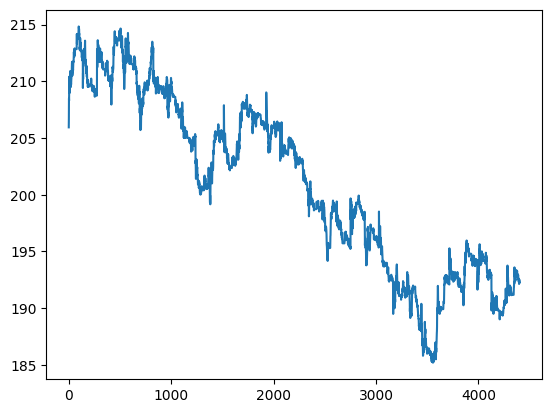

In [9]:
data["Adj Close"].plot()

In [10]:
data.drop(["Datetime","Date"], axis=1).corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999534,0.999590,0.999206,0.999206,0.023723
High,0.999534,1.000000,0.999266,0.999610,0.999610,0.028880
Low,0.999590,0.999266,1.000000,0.999569,0.999569,0.021183
Close,0.999206,0.999610,0.999569,1.000000,1.000000,0.025959
Adj Close,0.999206,0.999610,0.999569,1.000000,1.000000,0.025959
Volume,0.023723,0.028880,0.021183,0.025959,0.025959,1.000000


In [11]:
seq = data.query("Date < '2023-03-27'").drop(["Datetime","Date"], axis=1).values
seq_col4_mean = seq[:,4].mean()
seq_col4_std = seq[:,4].std()

In [12]:
def create_dataset(sequence, look_back, look_forward):
    data, target = [], []
    for i in range(len(sequence)-look_back-look_forward):
        data.append(sequence[i:i+look_back])
        target.append(sequence[i+look_back:i+look_back+look_forward,4])
    return np.array(data), np.array(target)

In [13]:
look_back = 5*136
look_forward = 136
input_shape = (look_back, 6)

In [14]:
ss = StandardScaler()
ss.fit(seq)
seq = ss.transform(seq)

In [15]:
X, y = create_dataset(seq, look_back, look_forward)
X.shape, y.shape

((3312, 680, 6), (3312, 136))

In [16]:
samples_num = X.shape[0]
train_x = X[:int(0.8*samples_num),:,:]
train_y = y[:int(0.8*samples_num),:]
val_x = X[:int(0.8*samples_num),:,:]
val_y = y[:int(0.8*samples_num),:]

In [17]:
model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(look_forward))
model.compile(loss='mse', optimizer='adam')

model.fit(X, y, epochs=100, batch_size=32)

Epoch 1/100


2023-03-30 12:44:54.062480: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


104/104 [==============================] - 12s 108ms/step - loss: 0.2070
Epoch 2/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0666
Epoch 3/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0621
Epoch 4/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0585
Epoch 5/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0574
Epoch 6/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0550
Epoch 7/100
104/104 [==============================] - 11s 108ms/step - loss: 0.0536
Epoch 8/100
104/104 [==============================] - 11s 109ms/step - loss: 0.0510
Epoch 9/100
104/104 [==============================] - 11s 110ms/step - loss: 0.0483
Epoch 10/100
104/104 [==============================] - 11s 110ms/step - loss: 0.0462
Epoch 11/100
104/104 [==============================] - 11s 110ms/step - loss: 0.0445
Epoch 12/100
104/104 [==============================] - 11s 110ms/step - lo

In [18]:
y_pred = model.predict(val_x)
y_pred.shape

83/83 [==============================] - 3s 28ms/step


(2649, 136)

In [19]:
val_y.shape

(2649, 136)

In [20]:
y_pred = y_pred*seq_col4_std + seq_col4_mean
val_y = val_y*seq_col4_std + seq_col4_mean

In [21]:
mean_absolute_error(val_y.flatten(), y_pred.flatten())

0.8394964515595055

In [22]:
data.query("Date >= '2023-03-20' and Date < '2023-03-29'").groupby("Date").size()

Date
2023-03-20    138
2023-03-21    138
2023-03-22    137
2023-03-23    136
2023-03-24    138
2023-03-27    138
2023-03-28    138
dtype: int64

In [23]:
test = data.query("Date >= '2023-03-20' and Date < '2023-03-29'").reset_index(drop=True)
test.query("Date >= '2023-03-27'")

,Datetime,Open,High,Low,Close,Adj Close,Volume,Date
687,2023-03-27 09:30:00+08:00,192.800003,192.800003,189.539993,189.800003,189.800003,698700,2023-03-27
688,2023-03-27 09:32:00+08:00,189.559998,190.500000,189.559998,190.350006,190.350006,340100,2023-03-27
689,2023-03-27 09:34:00+08:00,190.289993,190.740005,190.289993,190.470001,190.470001,206400,2023-03-27
690,2023-03-27 09:36:00+08:00,190.449997,190.449997,190.000000,190.009995,190.009995,248599,2023-03-27
691,2023-03-27 09:38:00+08:00,190.009995,190.839996,189.919998,190.500000,190.500000,138500,2023-03-27
...,...,...,...,...,...,...,...,...
958,2023-03-28 14:48:00+08:00,192.270004,192.360001,192.240005,192.339996,192.339996,73300,2023-03-28
959,2023-03-28 14:50:00+08:00,192.339996,192.339996,192.210007,192.220001,192.220001,86100,2023-03-28
960,2023-03-28 14:52:00+08:00,192.220001,192.449997,192.220001,192.380005,192.380005,115600,2023-03-28
961,2023-03-28 14:54:00+08:00,192.369995,192.429993,192.220001,192.389999,192.389999,146635,2023-03-28


In [24]:
136*5

680

In [25]:
test[7:687].shape

(680, 8)

In [26]:
train_x.shape, val_x.shape

((2649, 680, 6), (2649, 680, 6))

In [27]:
t1 = test[7:687].drop(["Datetime","Date"], axis=1).values

In [28]:
test.query("Date=='2023-03-28'")

,Datetime,Open,High,Low,Close,Adj Close,Volume,Date
825,2023-03-28 09:30:00+08:00,190.300003,191.440002,190.300003,191.419998,191.419998,108500,2023-03-28
826,2023-03-28 09:32:00+08:00,191.440002,191.940002,191.300003,191.729996,191.729996,324900,2023-03-28
827,2023-03-28 09:34:00+08:00,191.710007,191.740005,190.770004,190.839996,190.839996,199400,2023-03-28
828,2023-03-28 09:36:00+08:00,190.740005,190.770004,190.460007,190.460007,190.460007,129900,2023-03-28
829,2023-03-28 09:38:00+08:00,190.470001,190.679993,190.470001,190.479996,190.479996,85300,2023-03-28
...,...,...,...,...,...,...,...,...
958,2023-03-28 14:48:00+08:00,192.270004,192.360001,192.240005,192.339996,192.339996,73300,2023-03-28
959,2023-03-28 14:50:00+08:00,192.339996,192.339996,192.210007,192.220001,192.220001,86100,2023-03-28
960,2023-03-28 14:52:00+08:00,192.220001,192.449997,192.220001,192.380005,192.380005,115600,2023-03-28
961,2023-03-28 14:54:00+08:00,192.369995,192.429993,192.220001,192.389999,192.389999,146635,2023-03-28


In [29]:
t2 = test[825-680:825].drop(["Datetime","Date"], axis=1).values

In [30]:
t1.shape, t2.shape

((680, 6), (680, 6))

In [31]:
transformed_t1 = ss.transform(t1).reshape(-1,680,6)
transformed_t2 = ss.transform(t2).reshape(-1,680,6)

In [32]:
y1_pred = model.predict(transformed_t1).reshape(136,1)
y1_pred = y1_pred*seq_col4_std + seq_col4_mean

1/1 [==============================] - 0s 20ms/step


In [33]:
y2_pred = model.predict(transformed_t2).reshape(136,1)
y2_pred = y2_pred*seq_col4_std + seq_col4_mean

1/1 [==============================] - 0s 19ms/step


In [34]:
y1_pred.shape, y2_pred.shape

((136, 1), (136, 1))

In [35]:
y1_true = test.query("Date=='2023-03-27'")["Adj Close"].values[:136].reshape(136,1)
y2_true = test.query("Date=='2023-03-28'")["Adj Close"].values[:136].reshape(136,1)

In [36]:
y1_true.shape, y2_true.shape

((136, 1), (136, 1))

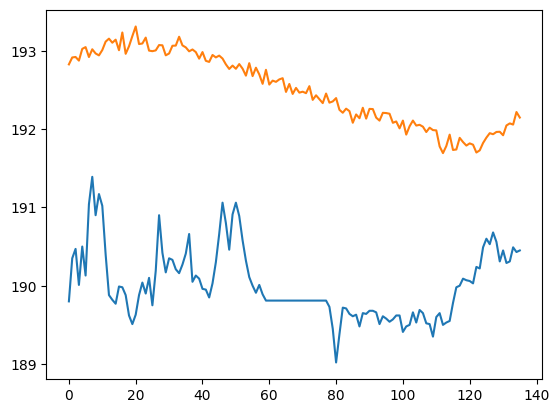

In [37]:
plt.plot(np.concatenate([y1_true, y1_pred], axis=1))

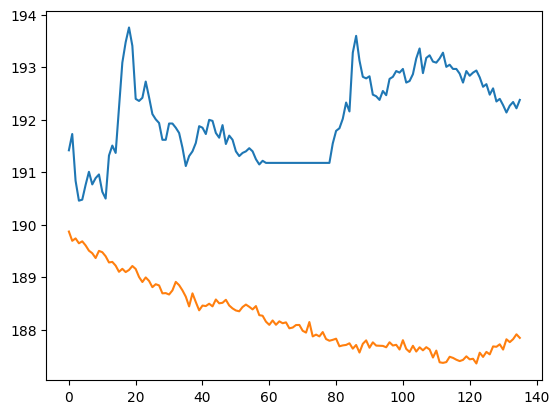

In [38]:
plt.plot(np.concatenate([y2_true, y2_pred], axis=1))

In [39]:
mean_absolute_error(y1_true, y1_pred), mean_absolute_error(y2_true, y2_pred)

(2.4861708248362886, 3.7966839285457836)